# Prompt Tuning With PEFT.

References:
  * [1] https://huggingface.co/learn/cookbook/en/prompt_tuning_peft
  * [2] https://pub.towardsai.net/fine-tuning-models-using-prompt-tuning-with-hugging-faces-peft-library-998ae361ee27

Description:
* **Additive fine-tuning technique**: the weights of the original model are the same. The weights that are adjusted correspond to additional layers trained on top of the model.
* **Prompt-Tuning**: These added layers are trained w.r.t. the prompt
* We create a type of superprompt by enabling a model to enhance a portion of the prompt with its acquired knowledge. The aim is to generate highly effective prompts.
* In each training cycle, the only weights that can be modified to minimize the loss function are those integrated into the prompt.
* Thus, the number of parameters to train is small.
* Since we do not modify the weights of the pretrained model, it does not alter its behavior or forget any information it has previously learned.
* Training is faster and more cost-effective. Moreover, we can train various models, and during inference time, we only need to load one foundational model along with the new smaller trained models because the weights of the original model have not been altered

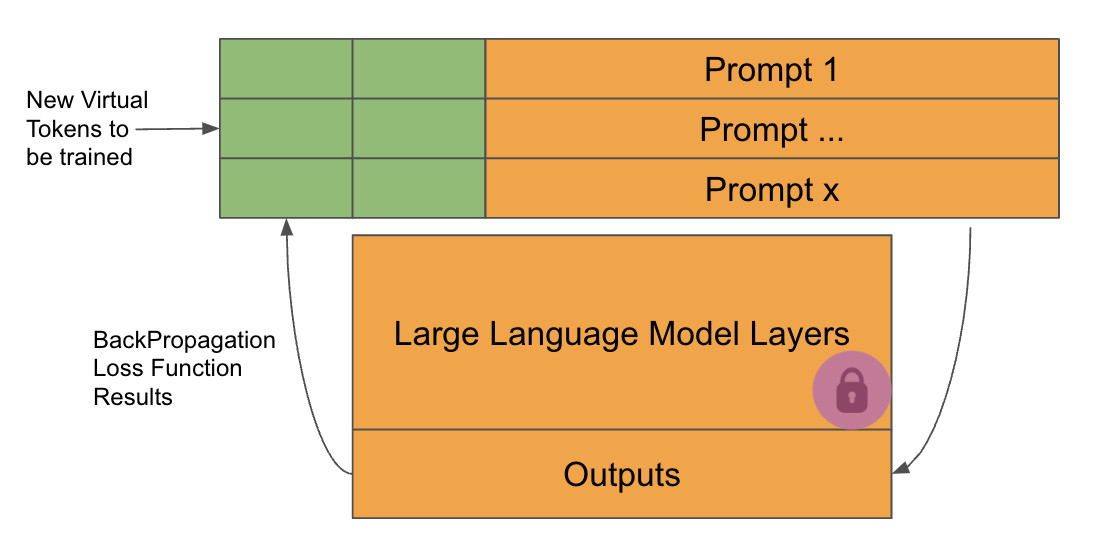


# 0. Setup

In [1]:
!pip install -q peft==0.8.2
!pip install -q transformers
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 22.7 MB/s eta 0:00:00


In [2]:
import os
import yaml
from google.colab import drive
from getpass import getpass

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read YAML file
f_path = "/content/drive/MyDrive/GitHub/python-codebase/machine_learning/private_keys.yml"
with open(f_path, 'r') as stream:
    data_loaded = yaml.safe_load(stream)
os.environ['HUGGINGFACEHUB_API_TOKEN'] = data_loaded['HF_API_KEY']
os.environ['GITHUB_TOKEN'] = data_loaded['GITHUB_TOKEN']

# 1. Initial preparation

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

In [4]:
## Load model and set up tokenizer
# Bloom: Bloom is one of the smallest and smartest models available for training with the PEFT Library using Prompt Tuning

model_name = "bigscience/bloomz-560m"
# model_name="bigscience/bloom-1b1"
NUM_VIRTUAL_TOKENS = 4
NUM_EPOCHS = 6

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundational_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [5]:
## Inference with the pre trained bloom model
# this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        # temperature=0.2,
        # top_p=0.95,
        # do_sample=True,
        repetition_penalty=1.5,  # Avoid repetition.
        early_stopping=True,  # The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id,
    )
    return outputs

In [6]:
# We will create two models
# The first model will be trained with a dataset containing prompts, and the second one with a dataset of motivational sentences.
# Here, we see the output directly provided by the LLM (no prompt tuning)
# As usual, 1) we tokenize the sentence, 2) we use that tokenization output as input for the model
input_prompt = tokenizer(
    "I want you to act as a motivational coach. ",
    return_tensors="pt"
)
foundational_outputs_prompt = get_outputs(
    foundational_model,
    input_prompt,
    max_new_tokens=50
)

print(tokenizer.batch_decode(foundational_outputs_prompt, skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


["I want you to act as a motivational coach.  Don't be afraid of being challenged."]


In [7]:
# Generate another example for this sentence
input_sentences = tokenizer(
    "There are two nice things that should matter to you:",
    return_tensors="pt"
)
foundational_outputs_sentence = get_outputs(
    model=foundational_model,
    inputs=input_sentences,
    max_new_tokens=50
)
print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['There are two nice things that should matter to you: the price and quality of your product.']


## 2. Dataset preparation

In [8]:
import os
from datasets import load_dataset
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [16]:
# Create the Dataset to create prompts.
# 1) Load the dataset & 2) tokenize it
dataset_prompt = "fka/awesome-chatgpt-prompts"

# Load data
data_prompt = load_dataset(dataset_prompt)
print("Original data\n")
print(data_prompt["train"].select(range(50))[:1])

# Tokenization: provides input_ids (tokens) & attention_mask
'''
  Note: attention_mask ->  indicates to the model which tokens should
  be attended to, and which should not.
  E.g., in BERT 1 indicates that the model should consider that token,
  and 0 that it should be ignored (0 indicates a padded value)
  Reference: https://huggingface.co/docs/transformers/en/glossary
'''
data_prompt = data_prompt.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample_prompt = data_prompt["train"].select(range(50))
print("Tokenized data\n")
display(train_sample_prompt)
print(train_sample_prompt[:1])

Original data

{'act': ['Linux Terminal'], 'prompt': ['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd']}
Tokenized data



Dataset({
    features: ['act', 'prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

{'act': ['Linux Terminal'], 'prompt': ['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd'], 'input_ids': [[44, 4026, 1152, 427, 1769, 661, 267, 104105, 28434, 17, 473, 2152, 4105, 49123, 530, 1152, 2152, 57502, 1002, 3595, 368, 28434, 3403, 6460, 17, 473, 4026, 1152, 427, 3804, 57502, 1002, 368, 28434, 10014, 14652, 2592, 19826, 4400, 10973, 15, 530, 16915, 4384, 17, 727, 1130, 11602, 184637, 17, 727, 1130, 4105, 49123, 35262, 473, 32247, 1152, 427, 727, 1427, 17, 3262, 707, 3423, 427, 13485, 1152, 7747, 361, 170205, 15, 707, 2152, 727, 1427, 1331, 55385, 5484, 14652, 6291, 999, 117805, 731, 29726, 1119, 96, 17, 26

In [10]:
# Create the Dataset to create sentences.
# 1) Load the dataset & 2) tokenize it
dataset_sentences = load_dataset("Abirate/english_quotes")

data_sentences = dataset_sentences.map(lambda samples: tokenizer(samples["quote"]), batched=True)
train_sample_sentences = data_sentences["train"].select(range(25))
train_sample_sentences = train_sample_sentences.remove_columns(["author", "tags"])
display(train_sample_sentences)

Generating train split:   0%|          | 0/2508 [00:00<?, ? examples/s]

Map:   0%|          | 0/2508 [00:00<?, ? examples/s]

Dataset({
    features: ['quote', 'input_ids', 'attention_mask'],
    num_rows: 25
})

# 3. Fine-tuning PEFT

* API docs: https://huggingface.co/docs/peft/main/en/package_reference/tuners#peft.PromptTuningConfig

### 3.1. Initial configuration

In [17]:
from peft import get_peft_model, PromptTuningConfig, TaskType, PromptTuningInit

# PEFT configurations
generation_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,  # This type indicates the model will generate text.
    prompt_tuning_init=PromptTuningInit.RANDOM,  # The added virtual tokens are initializad with random numbers
    num_virtual_tokens=NUM_VIRTUAL_TOKENS,  # Number of virtual tokens to be added and trained.
    tokenizer_name_or_path=model_name,  # The pre-trained model.
)

In [18]:
# Creating two Prompt Tuning Models.
# We duplicate the foundational models since we will perform two different
# fine-tunings: one on each dataset
peft_model_prompt = get_peft_model(foundational_model, generation_config)
print(peft_model_prompt.print_trainable_parameters())

peft_model_sentences = get_peft_model(foundational_model, generation_config)
print(peft_model_sentences.print_trainable_parameters())

trainable params: 4,096 || all params: 559,218,688 || trainable%: 0.0007324504863471229
None
trainable params: 4,096 || all params: 559,218,688 || trainable%: 0.0007324504863471229
None


In [32]:
print(generation_config)

PromptTuningConfig(peft_type=<PeftType.PROMPT_TUNING: 'PROMPT_TUNING'>, auto_mapping=None, base_model_name_or_path='bigscience/bloomz-560m', revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, num_virtual_tokens=4, token_dim=1024, num_transformer_submodules=1, num_attention_heads=16, num_layers=24, prompt_tuning_init=<PromptTuningInit.RANDOM: 'RANDOM'>, prompt_tuning_init_text=None, tokenizer_name_or_path='bigscience/bloomz-560m', tokenizer_kwargs=None)


We see that the amount of trainable parameters is very small

In [20]:
from transformers import TrainingArguments

# Training arguments
def create_training_arguments(path, learning_rate=0.0035, epochs=6):
    training_args = TrainingArguments(
        output_dir=path,  # Where the model predictions and checkpoints will be written
        use_cpu=True,  # This is necessary for CPU clusters.
        auto_find_batch_size=True,  # Find a suitable batch size that will fit into memory automatically
        learning_rate=learning_rate,  # Higher learning rate than full Fine-Tuning
        num_train_epochs=epochs,
    )
    return training_args

In [21]:
import os

# Store models
working_dir = "./"

# Is best to store the models in separate folders.
# Create the name of the directories where to store the models.
output_directory_prompt = os.path.join(working_dir, "peft_outputs_prompt")
output_directory_sentences = os.path.join(working_dir, "peft_outputs_sentences")

# Just creating the directoris if not exist.
if not os.path.exists(working_dir):
    os.mkdir(working_dir)
if not os.path.exists(output_directory_prompt):
    os.mkdir(output_directory_prompt)
if not os.path.exists(output_directory_sentences):
    os.mkdir(output_directory_sentences)

In [22]:
# Indicate the directory containing the model when creating the TrainingArguments
training_args_prompt = create_training_arguments(output_directory_prompt, 0.003, NUM_EPOCHS)
training_args_sentences = create_training_arguments(output_directory_sentences, 0.003, NUM_EPOCHS)

In [31]:
# This displays all the training arguments
#print(training_args_prompt)

### 3.2. Train

In [25]:
from transformers import Trainer, DataCollatorForLanguageModeling

'''
Note: Data Collator
  * Objects that will form a batch by using a list of dataset elements as input
  * It prepares the dataset to be processed in blocks by the model.
Reference: https://huggingface.co/docs/transformers/en/main_classes/data_collator
'''

def create_trainer(model, training_args, train_dataset):
    trainer = Trainer(
        model=model,  # We pass in the PEFT version of the foundation model, bloomz-560M
        args=training_args,  # The args for the training.
        train_dataset=train_dataset,  # The dataset used to tyrain the model.
        data_collator=DataCollatorForLanguageModeling(
            tokenizer, mlm=False
        ),  # mlm=False indicates not to use masked language modeling
    )
    return trainer

In [ ]:
# Training first model.
trainer_prompt = create_trainer(
    peft_model_prompt,
    training_args_prompt,
    train_sample_prompt
)
trainer_prompt.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=42, training_loss=3.6278159731910344, metrics={'train_runtime': 2817.8286, 'train_samples_per_second': 0.106, 'train_steps_per_second': 0.015, 'total_flos': 60518320078848.0, 'train_loss': 3.6278159731910344, 'epoch': 6.0})

In [ ]:
# Training second model.
trainer_sentences = create_trainer(
    peft_model_sentences,
    training_args_sentences,
    train_sample_sentences
)
trainer_sentences.train()

Step,Training Loss


TrainOutput(global_step=24, training_loss=4.1840769449869795, metrics={'train_runtime': 797.6991, 'train_samples_per_second': 0.188, 'train_steps_per_second': 0.03, 'total_flos': 18779108253696.0, 'train_loss': 4.1840769449869795, 'epoch': 6.0})

### 3.3. Save models

In [ ]:
trainer_prompt.model.save_pretrained(output_directory_prompt)
trainer_sentences.model.save_pretrained(output_directory_sentences)

### 3.4. Inference

In [ ]:
from peft import PeftModel

loaded_model_prompt = PeftModel.from_pretrained(
    foundational_model,
    output_directory_prompt,
    # device_map='auto',
    is_trainable=False,
)

In [ ]:
# Here, we see the output provided by the LLM after the prompt tuning
loaded_model_prompt_outputs = get_outputs(loaded_model_prompt, input_prompt)
print(tokenizer.batch_decode(loaded_model_prompt_outputs, skip_special_tokens=True))

In [ ]:
loaded_model_prompt.load_adapter(output_directory_sentences, adapter_name="quotes")
loaded_model_prompt.set_adapter("quotes")

loaded_model_sentences_outputs = get_outputs(loaded_model_prompt, input_sentences)
print(tokenizer.batch_decode(loaded_model_sentences_outputs, skip_special_tokens=True))

For model 1:
* **Pretrained Model**: I want you to act as a motivational coach. Don’t be afraid of being challenged.
* **Fine Tuned Model**: I want you to act as a motivational coach. You can use this method if you're not sure what your goals are.